# Visualization

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import duckdb
import kagglehub
import matplotlib.pyplot as plt

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
cleaned_parquet_path = "./cleaned_data/cleaned_fraud.parquet"

# 1. Check if source Parquet exists
if not os.path.exists(cleaned_parquet_path):
    raise FileNotFoundError(f"Parquet file not found at {cleaned_parquet_path}")

print(f"📁 Target Cleaned Parquet: {cleaned_parquet_path}")
print(f"📊 Original size: {os.path.getsize(cleaned_parquet_path) / (1024**3):.2f} GB")


📁 Target Cleaned Parquet: ./cleaned_data/cleaned_fraud.parquet
📊 Original size: 0.14 GB


In [27]:
df = pd.read_parquet(cleaned_parquet_path)
df.head()

,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,year,month,day_of_month,hour,day_of_week
0,ACC420214,ACC222629,318.12,withdrawal,restaurant,Tokyo,pos,False,-4797.552868,-0.94,16,0.64,UPI,88.85.250.147,D3353785,2023,4,25,14,2
1,ACC759858,ACC433871,25.03,transfer,online,Dubai,pos,False,3705.738348,-0.56,1,0.48,ACH,89.235.76.67,D4950912,2023,8,17,1,4
2,ACC702235,ACC658588,5.33,transfer,online,Toronto,pos,False,2158.906433,0.77,7,0.18,ACH,132.247.155.53,D9285320,2023,12,28,23,4
3,ACC818001,ACC846452,261.11,payment,entertainment,Tokyo,atm,False,-71.393848,0.43,12,0.41,wire_transfer,186.251.230.65,D4842173,2023,8,18,9,5
4,ACC293626,ACC440136,28.61,transfer,retail,London,pos,False,1400.413482,-1.48,18,0.53,UPI,233.115.221.14,D7106200,2023,10,30,9,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4103487 entries, 0 to 4103486
Data columns (total 20 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   sender_account               object 
 1   receiver_account             object 
 2   amount                       float64
 3   transaction_type             object 
 4   merchant_category            object 
 5   location                     object 
 6   device_used                  object 
 7   is_fraud                     bool   
 8   time_since_last_transaction  float64
 9   spending_deviation_score     float64
 10  velocity_score               int64  
 11  geo_anomaly_score            float64
 12  payment_channel              object 
 13  ip_address                   object 
 14  device_hash                  object 
 15  year                         int64  
 16  month                        int64  
 17  day_of_month                 int64  
 18  hour                         int64  
 19  

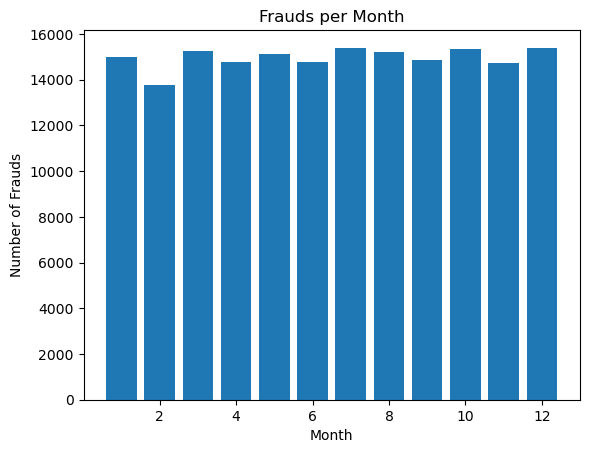

In [29]:
# Connect to an in-memory DuckDB database
con = duckdb.connect()

# Create a SQL view from the Parquet file
con.execute("""
    CREATE VIEW fraud_data AS
    SELECT * FROM read_parquet("./cleaned_data/cleaned_fraud.parquet")
""")

# Run a SQL query: count frauds per month
result = con.execute("""
    SELECT month, COUNT(*) AS num_frauds
    FROM fraud_data
    WHERE is_fraud = TRUE
    GROUP BY month
    ORDER BY month
""").fetchall()

# Convert query results into lists for plotting
months = [row[0] for row in result]
counts = [row[1] for row in result]

# Plotting
plt.bar(months, counts)
plt.xlabel("Month")
plt.ylabel("Number of Frauds")
plt.title("Frauds per Month")
plt.show()



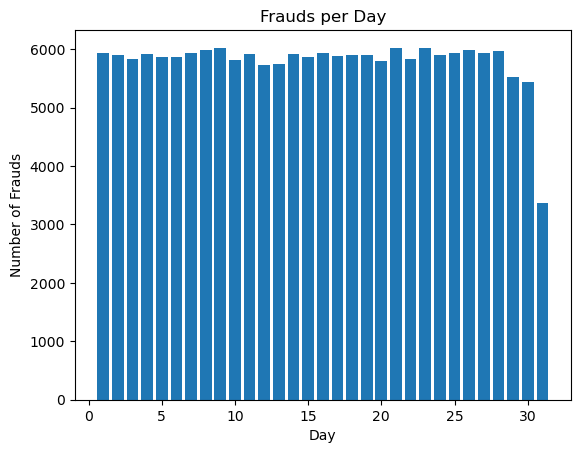

In [ ]:
# Run a SQL query: count frauds per month
result = con.execute("""
    SELECT day_of_month, COUNT(*) AS num_frauds
    FROM fraud_data
    WHERE is_fraud = TRUE
    GROUP BY day_of_month
    ORDER BY day_of_month
""").fetchall()

# Convert query results into lists for plotting
months = [row[0] for row in result]
counts = [row[1] for row in result]

# Plotting
plt.bar(months, counts)
plt.xlabel("Day")
plt.ylabel("Number of Frauds")
plt.title("Frauds per Day of The Month")
plt.show()

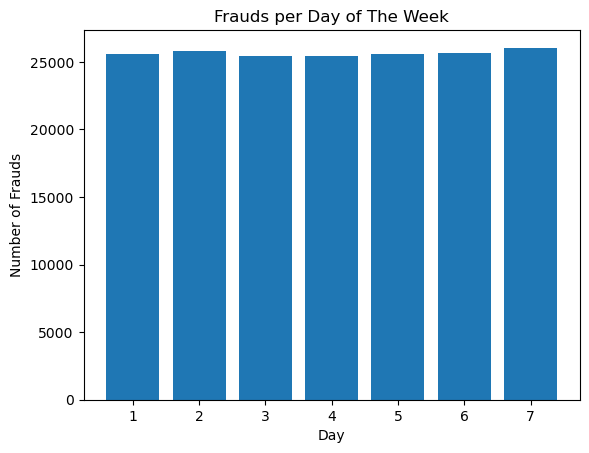

In [9]:
# Run a SQL query: count frauds per month
result = con.execute("""
    SELECT day_of_week, COUNT(*) AS num_frauds
    FROM fraud_data
    WHERE is_fraud = TRUE
    GROUP BY day_of_week
    ORDER BY day_of_week
""").fetchall()

# Convert query results into lists for plotting
months = [row[0] for row in result]
counts = [row[1] for row in result]

# Plotting
plt.bar(months, counts)
plt.xlabel("Day")
plt.ylabel("Number of Frauds")
plt.title("Frauds per Day of The Week")
plt.show()

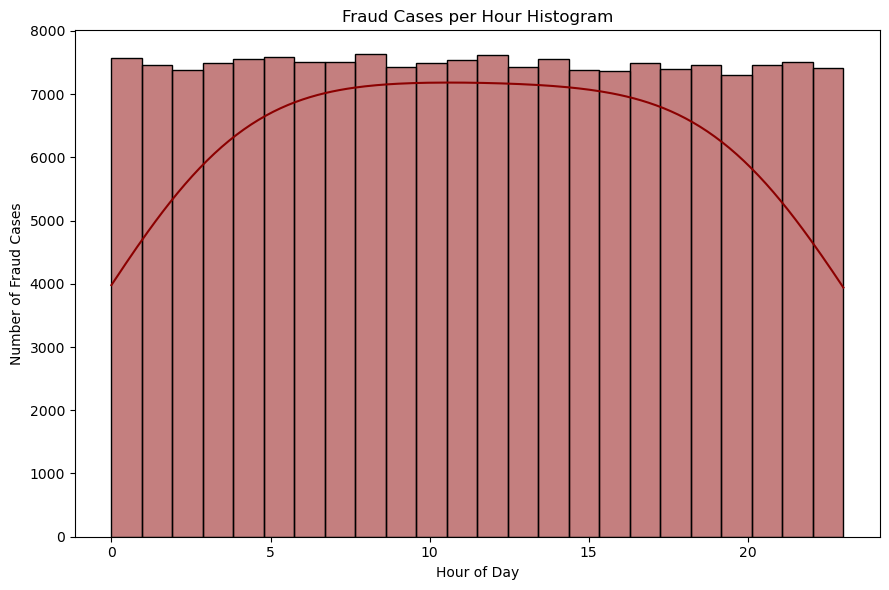

In [10]:
# Run a SQL query: count frauds per month
result = con.execute("""
    SELECT hour, COUNT(*) AS num_frauds
    FROM fraud_data
    WHERE is_fraud = TRUE
    GROUP BY hour
    ORDER BY hour
""").fetchall()

# Assuming `result` from DuckDB query
df_result = pd.DataFrame(result, columns=['hour', 'num_frauds'])

# Plot histogram
fig, ax = plt.subplots(figsize=(9,6))

sns.histplot(
    data=df_result,
    x='hour',
    weights='num_frauds',  # Use the counts from SQL
    bins=24,
    color='darkred',
    kde=True,
    ax=ax
)

ax.set_title("Fraud Cases per Hour Histogram")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()

In [11]:
# Create fraud_df with only fraud-positive cases
fraud_df = df[df["is_fraud"] == True].copy()

# Preview first rows
fraud_df.head()

,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,year,month,day_of_month,hour,day_of_week
21,ACC391250,ACC499875,50.80,withdrawal,online,Tokyo,mobile,True,-4435.604463,-1.18,16,0.51,ACH,207.94.248.163,D9978939,2023,2,27,9,1
124,ACC853799,ACC774781,1099.03,deposit,grocery,Berlin,atm,True,-543.435253,0.18,8,0.47,UPI,34.66.126.237,D9225721,2023,3,11,4,6
256,ACC743015,ACC311170,18.73,transfer,retail,Berlin,atm,True,3339.160882,0.57,10,0.50,ACH,115.218.159.229,D6163373,2023,9,21,23,4
324,ACC693265,ACC304655,1057.66,deposit,other,Singapore,mobile,True,-5616.318212,-0.11,1,0.93,ACH,102.102.14.51,D1201766,2023,3,23,18,4
326,ACC773851,ACC321187,26.36,payment,other,Tokyo,pos,True,-2102.467519,-0.06,7,0.22,UPI,134.105.153.161,D6904335,2023,3,1,15,3


In [12]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179553 entries, 21 to 4103427
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   sender_account               179553 non-null  object 
 1   receiver_account             179553 non-null  object 
 2   amount                       179553 non-null  float64
 3   transaction_type             179553 non-null  object 
 4   merchant_category            179553 non-null  object 
 5   location                     179553 non-null  object 
 6   device_used                  179553 non-null  object 
 7   is_fraud                     179553 non-null  bool   
 8   time_since_last_transaction  179553 non-null  float64
 9   spending_deviation_score     179553 non-null  float64
 10  velocity_score               179553 non-null  int64  
 11  geo_anomaly_score            179553 non-null  float64
 12  payment_channel              179553 non-null  object 
 13  ip

<Axes: xlabel='transaction_type', ylabel='count'>

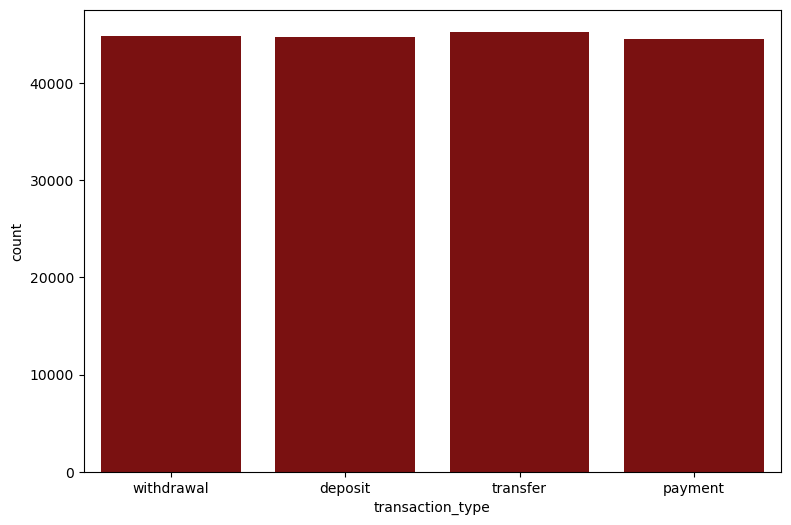

In [13]:
#count per categorie. Transaction Type in fraud dataset

# Create a bar count plot with Seaborn
fig, ax1 = plt.subplots(figsize=(9,6))
sns.countplot(
    data=fraud_df,
    x='transaction_type',
    color='darkred',
    ax=ax1)




<Axes: xlabel='device_used', ylabel='count'>

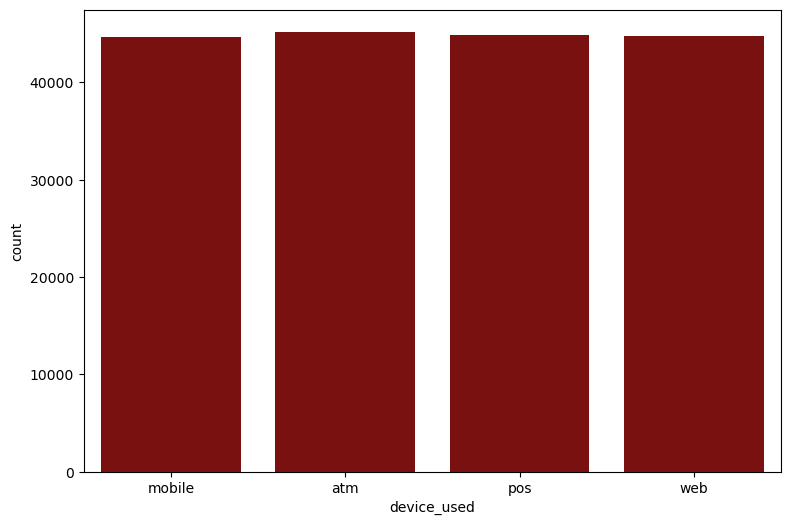

In [14]:
#count per categorie. device_used in fraud dataset

# Create a bar count plot with Seaborn
fig, ax1 = plt.subplots(figsize=(9,6))
sns.countplot(
    data=fraud_df,
    x='device_used',
    color='darkred',
    ax=ax1)

<Axes: xlabel='merchant_category', ylabel='count'>

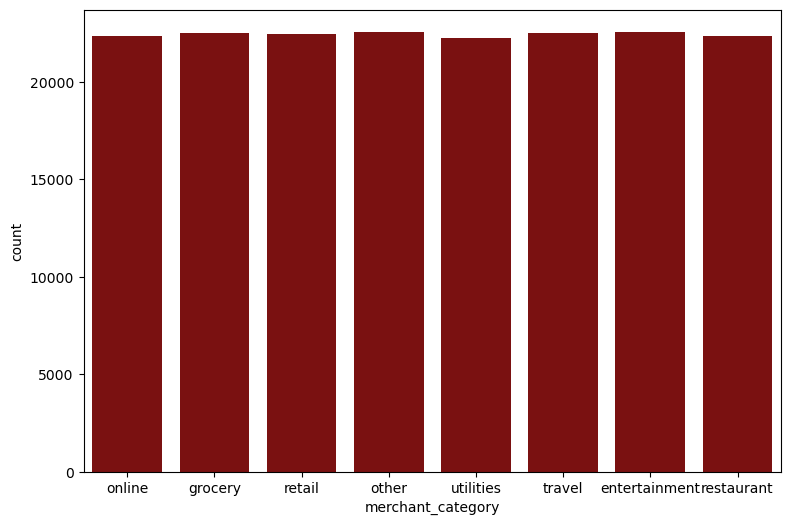

In [15]:
#count per categorie. merchant_category in fraud dataset

# Create a bar count plot with Seaborn
fig, ax1 = plt.subplots(figsize=(9,6))
sns.countplot(
    data=fraud_df,
    x='merchant_category',
    color='darkred',
    ax=ax1)

<Axes: xlabel='location', ylabel='count'>

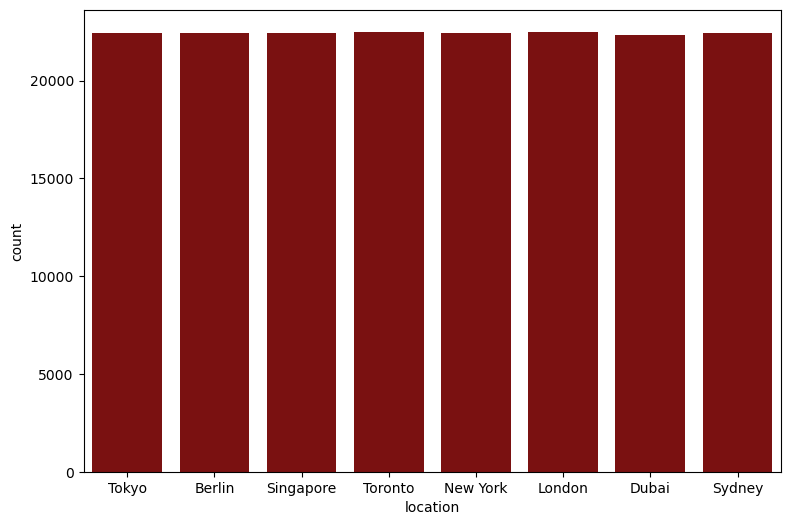

In [16]:

#count per categorie. location in fraud dataset

# Create a bar count plot with Seaborn
fig, ax1 = plt.subplots(figsize=(9,6))
sns.countplot(
    data=fraud_df,
    x='location',
    color='darkred',
    ax=ax1)

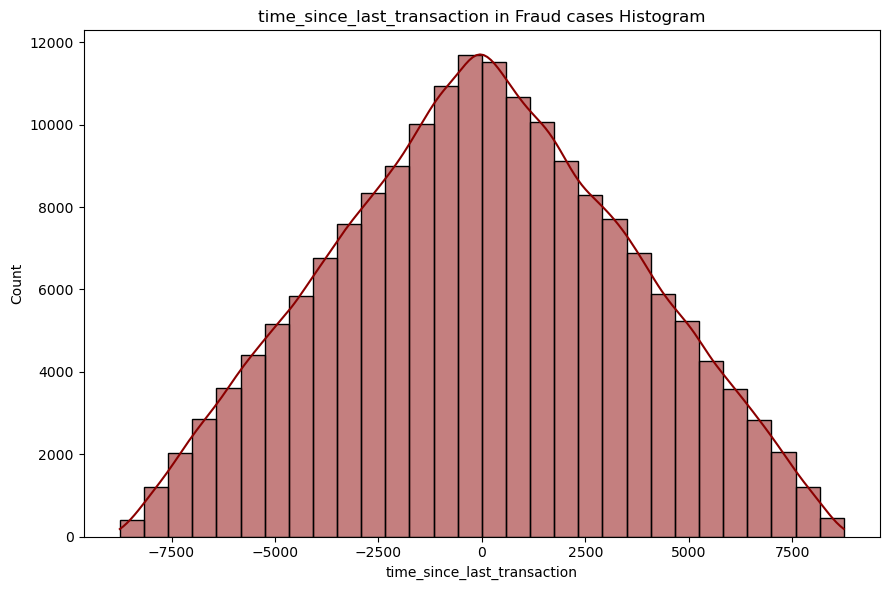

In [17]:
fig, ax = plt.subplots(figsize=(9,6))

sns.histplot(
    data=fraud_df,
    x='time_since_last_transaction',
    bins=30,          # Numner of bins
    color='darkred',
    kde=True,         # Lines
    ax=ax
)

ax.set_title("time_since_last_transaction in Fraud cases Histogram")
plt.tight_layout()
plt.show()

- it is Fraud is the label, the target, the variable to predict, it is not included in the visualization to see the patterns. 
- Negative values because of the time diference. 


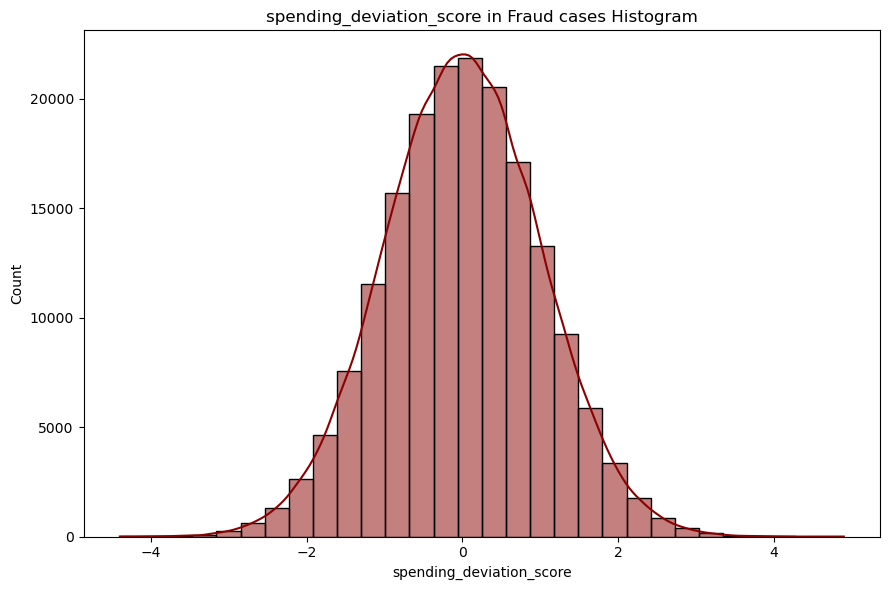

In [18]:
#spending_deviation_score Hisogram

fig, ax = plt.subplots(figsize=(9,6))

sns.histplot(
    data=fraud_df,
    x='spending_deviation_score',
    bins=30,          # Numner of bins
    color='darkred',
    kde=True,         # Lines
    ax=ax
)

ax.set_title("spending_deviation_score in Fraud cases Histogram")
plt.tight_layout()
plt.show()

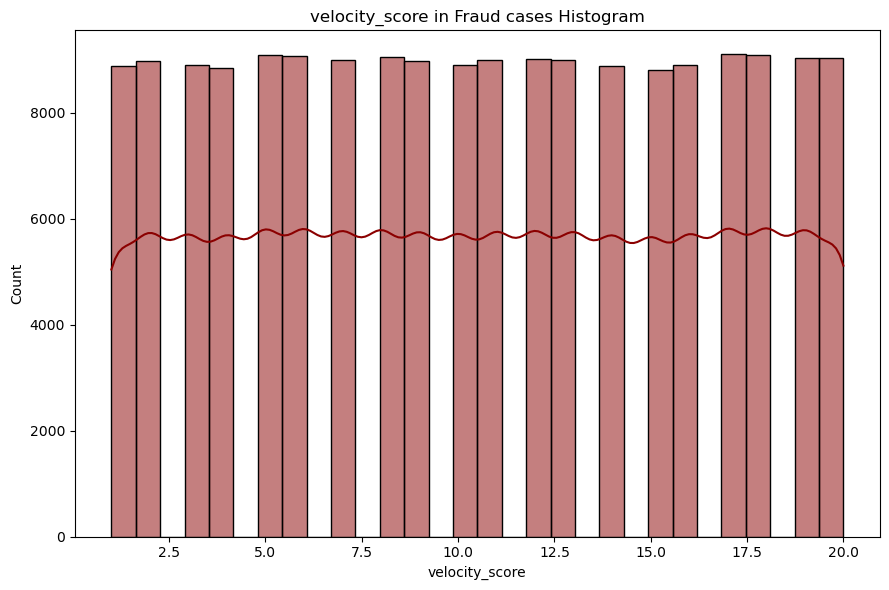

In [31]:

#velocity_score Hisogram

fig, ax = plt.subplots(figsize=(9,6))

sns.histplot(
    data=fraud_df,
    x='velocity_score',
    bins=30,          # Numner of bins
    color='darkred',
    kde=True,         # Lines
    ax=ax
)

ax.set_title("velocity_score in Fraud cases Histogram")
plt.tight_layout()
plt.show()

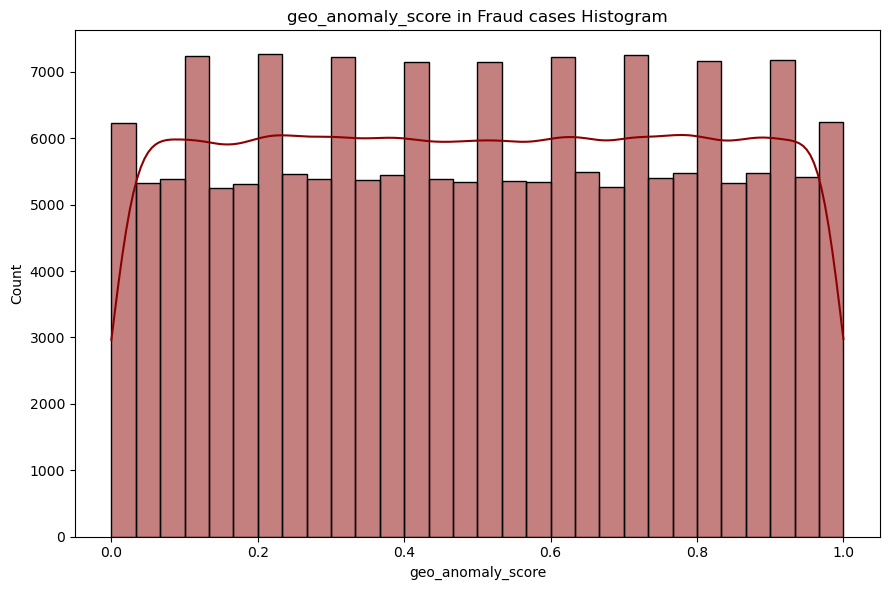

In [32]:

#geo_anomaly_score Hisogram

fig, ax = plt.subplots(figsize=(9,6))

sns.histplot(
    data=fraud_df,
    x='geo_anomaly_score',
    bins=30,          # Numner of bins
    color='darkred',
    kde=True,         # Lines
    ax=ax
)

ax.set_title("geo_anomaly_score in Fraud cases Histogram")
plt.tight_layout()
plt.show()

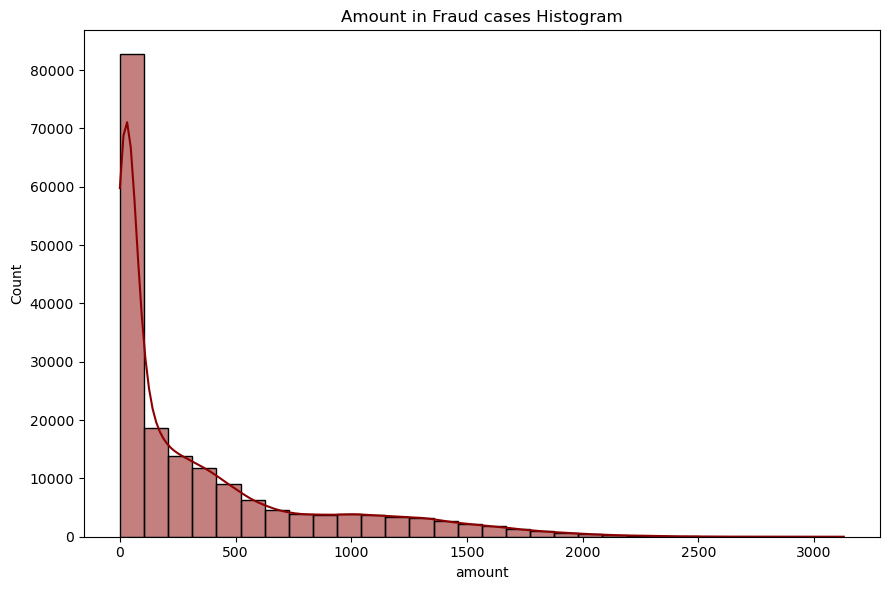

In [35]:
fig, ax = plt.subplots(figsize=(9,6))

sns.histplot(
    data=fraud_df,
    x='amount',
    bins=30,          # Numner of bins
    color='darkred',
    kde=True,         # Lines
    ax=ax
)

ax.set_title("Amount in Fraud cases Histogram")
plt.tight_layout()
plt.show()

